## Import Library ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import random
import nltk
nltk.download('punkt')

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from transformers import BertConfig, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight

# Transformers library for DistilBERT
import transformers
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification,DistilBertConfig, DistilBertModel
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from torch import nn
import time

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-05-26 13:35:49.536588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748266549.770895      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748266549.835360      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Input Data ##

In [2]:
# Membaca dataset dari file CSV
import pandas as pd
data_train = pd.read_csv('/kaggle/input/data-tts-802020/Data_Augmentasi_Back_Translation_Kompre1.csv')
data_test = pd.read_csv('/kaggle/input/data-tts-802020/Data_test (80).csv')
data_val = pd.read_csv('/kaggle/input/data-tts-802020/Data_val (80).csv')

# Menampilkan ketiga dataframe secara terpisah
print("Data Train:")
print(data_train.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Test:")
print(data_test.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Validation:")
print(data_val.head())

Data Train:
                                           statement      status
0  i ve thought of ending my life so many time bu...  Depression
1  there is nothing to look forward to just the s...  Depression
2                 just realized im talking to no one      Normal
3  husband stayed home from work today again hes ...     Bipolar
4  it feels like i am being punished for having i...  Depression


Data Test:
                                           statement      status
0  morning good im bloody knackered work is not f...      Normal
1  i have no will to live anymore but i cant kill...  Depression
2  did everyone else get strip searched when they...     Bipolar
3  the problem is that i have zero support system...      Stress
4  best mood tracker app my mood is being wack de...     Bipolar


Data Validation:
                                           statement                status
0  every night overthinking anxious nervousevery ...               Anxiety
1  do therapists even unde

In [3]:
data_train

,statement,status
0,i ve thought of ending my life so many time bu...,Depression
1,there is nothing to look forward to just the s...,Depression
2,just realized im talking to no one,Normal
3,husband stayed home from work today again hes ...,Bipolar
4,it feels like i am being punished for having i...,Depression
...,...,...
27859,seeing my therapist makes me like shit on a re...,Bipolar
27860,stable for years hey everyone thank you for ta...,Bipolar
27861,im reading a book cover to cover today ive got...,Bipolar
27862,i can be pretty dangerous im like a scared tee...,Bipolar


In [4]:
data_test

,statement,status
0,morning good im bloody knackered work is not f...,Normal
1,i have no will to live anymore but i cant kill...,Depression
2,did everyone else get strip searched when they...,Bipolar
3,the problem is that i have zero support system...,Stress
4,best mood tracker app my mood is being wack de...,Bipolar
...,...,...
4659,oh all over the world,Normal
4660,sorry beauty i dont understand makeup and i wa...,Normal
4661,lets start again no one replies to my chats,Normal
4662,i just cant do it anymore i cant handle the st...,Stress


In [5]:
data_val

,statement,status
0,every night overthinking anxious nervousevery ...,Anxiety
1,do therapists even understand avpd i generally...,Personality disorder
2,meh almost lover is the exception this track g...,Normal
3,i have no friends or boyfriend im f and i have...,Depression
4,afraid to get worked up i posted here befpre a...,Anxiety
...,...,...
3726,on therapy my therapist is very talented in fa...,Bipolar
3727,edit in the wonderful world of good news the u...,Normal
3728,right now i am practically shaking there is kn...,Depression
3729,xdcd what are you saying about yourself,Normal


## Visualisasi Distribusi Data ##

In [6]:
data_train['status'].value_counts()

status
Normal                  4904
Stress                  4904
Bipolar                 4898
Anxiety                 4893
Depression              4837
Personality disorder    3428
Name: count, dtype: int64

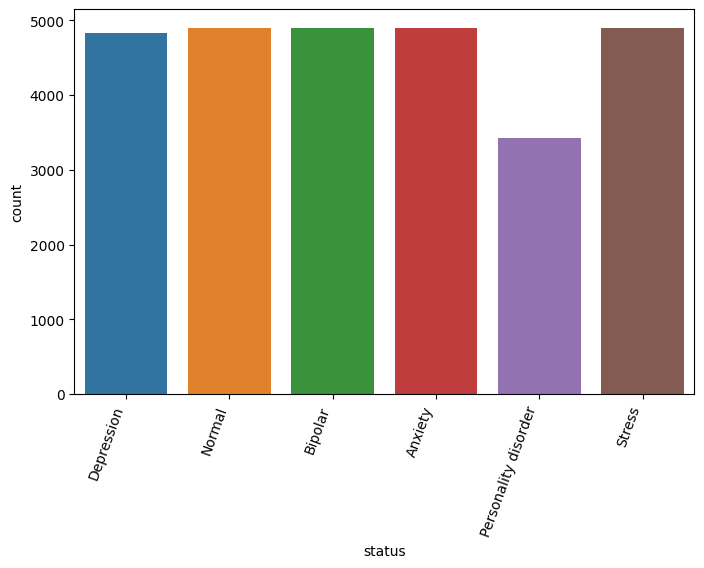

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x = data_train.status)
plt.xticks(rotation=70, ha='right')
plt.show()

In [8]:
data_test['status'].value_counts()

status
Normal                  1533
Depression              1397
Anxiety                  677
Bipolar                  455
Stress                   438
Personality disorder     164
Name: count, dtype: int64

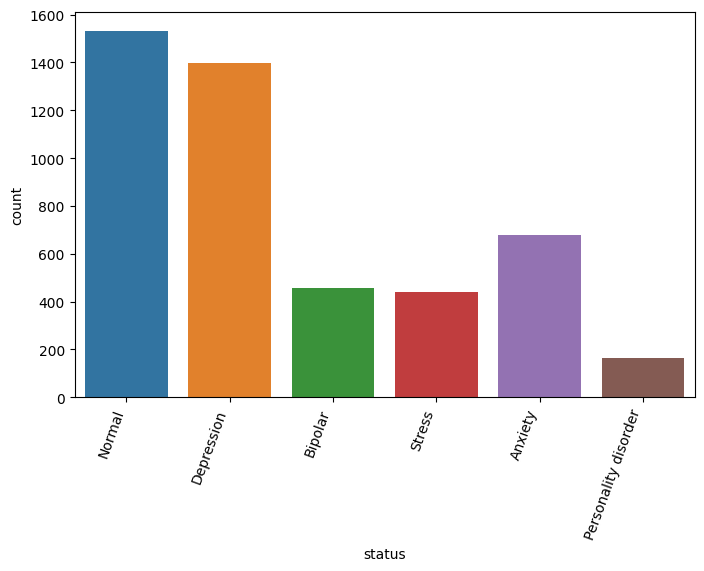

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x = data_test.status)
plt.xticks(rotation=70, ha='right')
plt.show()

In [10]:
data_val['status'].value_counts()

status
Normal                  1226
Depression              1117
Anxiety                  541
Bipolar                  365
Stress                   350
Personality disorder     132
Name: count, dtype: int64

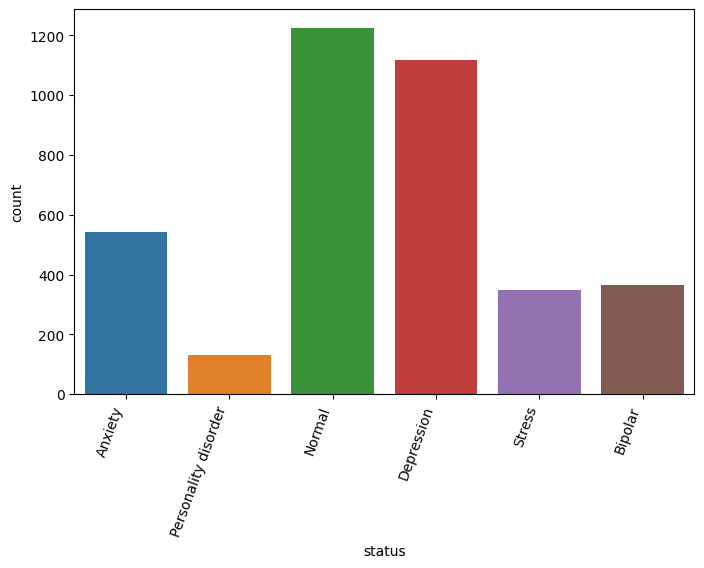

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(x = data_val.status)
plt.xticks(rotation=70, ha='right')
plt.show()

## Pengecekan Missing Value & Data Duplikat ##

In [12]:
# Menampilkan jumlah missing values untuk setiap dataframe
print("Missing values in data_train:")
print(data_train.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

print("Missing values in data_test:")
print(data_test.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

print("Missing values in data_val:")
print(data_val.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

Missing values in data_train:
statement    1
status       0
dtype: int64


Missing values in data_test:
statement    0
status       0
dtype: int64


Missing values in data_val:
statement    0
status       0
dtype: int64




In [13]:
data_train = data_train.dropna()
data_test = data_test.dropna()
data_val = data_val.dropna()

In [14]:
# Menampilkan jumlah missing values untuk setiap dataframe
print("Missing values in data_train:")
print(data_train.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

print("Missing values in data_test:")
print(data_test.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

print("Missing values in data_val:")
print(data_val.isnull().sum())
print("\n")  # Baris kosong untuk pemisah

Missing values in data_train:
statement    0
status       0
dtype: int64


Missing values in data_test:
statement    0
status       0
dtype: int64


Missing values in data_val:
statement    0
status       0
dtype: int64




In [15]:
print("Data Duplicated in data_train:")
print(data_train.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

print("Data Duplicated in data_test:")
print(data_test.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

print("Data Duplicated in data_val:")
print(data_val.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

Data Duplicated in data_train:
0


Data Duplicated in data_test:
0


Data Duplicated in data_val:
0




In [16]:
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()
data_val = data_val.drop_duplicates()

In [17]:
print("Data Duplicated in data_train:")
print(data_train.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

print("Data Duplicated in data_test:")
print(data_test.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

print("Data Duplicated in data_val:")
print(data_val.duplicated().sum())
print("\n")  # Baris kosong untuk pemisah

Data Duplicated in data_train:
0


Data Duplicated in data_test:
0


Data Duplicated in data_val:
0




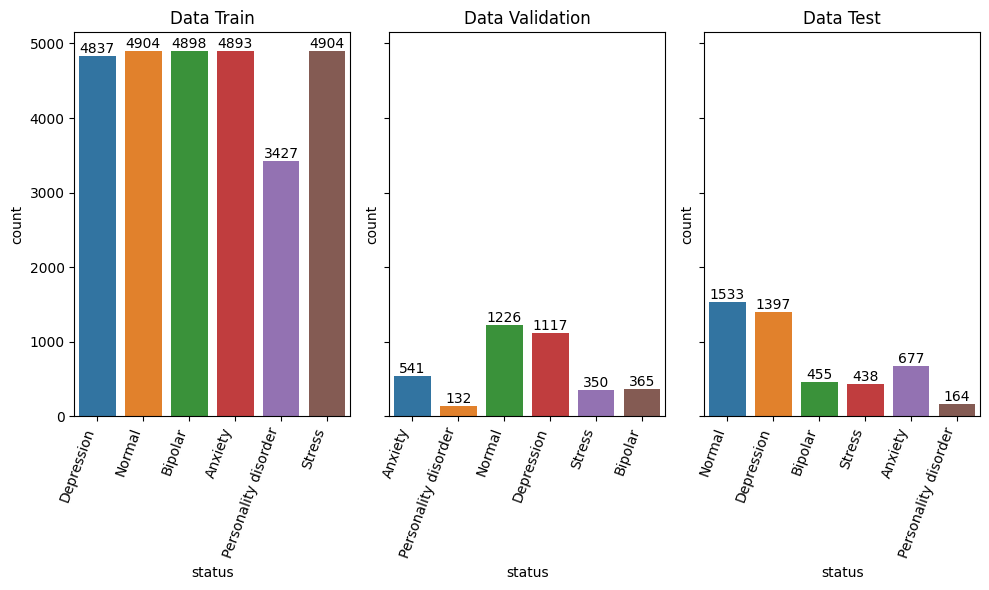

In [18]:
# Membuat figure dan axes untuk 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

# Plot untuk data_train
sns.countplot(ax=axes[0], x=data_train['status'])
axes[0].set_title('Data Train')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=70, ha='right')
for bar in axes[0].containers:
    axes[0].bar_label(bar)

# Plot untuk data_val
sns.countplot(ax=axes[1], x=data_val['status'])
axes[1].set_title('Data Validation')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=70, ha='right')
for bar in axes[1].containers:
    axes[1].bar_label(bar)

# Plot untuk data_test
sns.countplot(ax=axes[2], x=data_test['status'])
axes[2].set_title('Data Test')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=70, ha='right')
for bar in axes[2].containers:
    axes[2].bar_label(bar)

# Menampilkan plot
plt.tight_layout()
plt.show()

## Menampilkan Panjang Teks ##

In [19]:
# Menambahkan kolom baru "panjang_kata" ke DataFrame
data_train['word_count'] = data_train['statement'].apply(lambda x: len(str(x).split()))
data_test['word_count'] = data_test['statement'].apply(lambda x: len(str(x).split()))
data_val['word_count'] = data_val['statement'].apply(lambda x: len(str(x).split()))

In [20]:
# Menampilkan ketiga dataframe secara terpisah
print("Data Train:")
print(data_train.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Test:")
print(data_test.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Validation:")
print(data_val.head())

Data Train:
                                           statement      status  word_count
0  i ve thought of ending my life so many time bu...  Depression         107
1  there is nothing to look forward to just the s...  Depression          46
2                 just realized im talking to no one      Normal           7
3  husband stayed home from work today again hes ...     Bipolar         102
4  it feels like i am being punished for having i...  Depression         166


Data Test:
                                           statement      status  word_count
0  morning good im bloody knackered work is not f...      Normal          13
1  i have no will to live anymore but i cant kill...  Depression          52
2  did everyone else get strip searched when they...     Bipolar         203
3  the problem is that i have zero support system...      Stress          83
4  best mood tracker app my mood is being wack de...     Bipolar         105


Data Validation:
                                

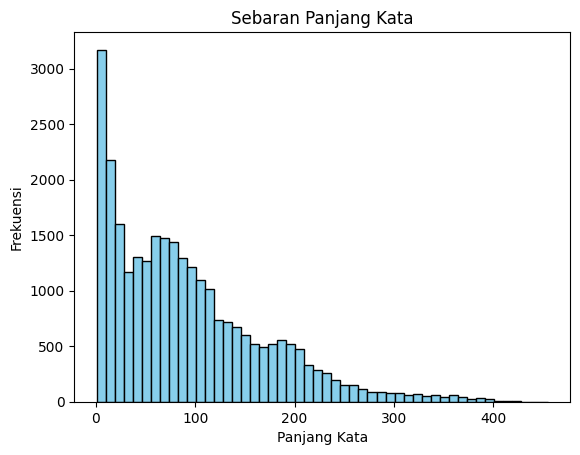

In [21]:
plt.hist(data_train['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Sebaran Panjang Kata')
plt.xlabel('Panjang Kata')
plt.ylabel('Frekuensi')
plt.show()

In [22]:
max_word_count_train = data_train['word_count'].max()
max_word_count_test = data_test['word_count'].max()
max_word_count_val = data_val['word_count'].max()

print("Max Word Count in data_train:", max_word_count_train)
print("Max Word Count in data_test:", max_word_count_test)
print("Max Word Count in data_val:", max_word_count_val)

Max Word Count in data_train: 455
Max Word Count in data_test: 439
Max Word Count in data_val: 443


In [23]:
data_train.drop(columns=['word_count'], inplace=True)
data_test.drop(columns=['word_count'], inplace=True)
data_val.drop(columns=['word_count'], inplace=True)

## Label Encoder ##

In [24]:
encoder = LabelEncoder()
data_train['status'] = encoder.fit_transform(data_train['status'])
data_test['status'] = encoder.fit_transform(data_test['status'])
data_val['status'] = encoder.fit_transform(data_val['status'])

In [25]:
print("Label unik di data_train:", data_train['status'].unique())
print("Label unik di data_test:", data_test['status'].unique())
print("Label unik di data_val:", data_val['status'].unique())

Label unik di data_train: [2 3 1 0 4 5]
Label unik di data_test: [3 2 1 5 0 4]
Label unik di data_val: [0 4 3 2 5 1]


In [26]:
# Menampilkan ketiga dataframe secara terpisah
print("Data Train:")
print(data_train.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Test:")
print(data_test.head()) 
print("\n")  # Baris kosong untuk pemisah

print("Data Validation:")
print(data_val.head())

Data Train:
                                           statement  status
0  i ve thought of ending my life so many time bu...       2
1  there is nothing to look forward to just the s...       2
2                 just realized im talking to no one       3
3  husband stayed home from work today again hes ...       1
4  it feels like i am being punished for having i...       2


Data Test:
                                           statement  status
0  morning good im bloody knackered work is not f...       3
1  i have no will to live anymore but i cant kill...       2
2  did everyone else get strip searched when they...       1
3  the problem is that i have zero support system...       5
4  best mood tracker app my mood is being wack de...       1


Data Validation:
                                           statement  status
0  every night overthinking anxious nervousevery ...       0
1  do therapists even understand avpd i generally...       4
2  meh almost lover is the exception this

## Tokenisasi ##

In [27]:
# Data Train
text_train = data_train['statement'].values
labels_train = data_train['status'].values

# Data Val
text_val = data_val['statement'].values
labels_val = data_val['status'].values

# Data Test
text_test = data_test['statement'].values
labels_test = data_test['status'].values

In [28]:
# Inisialisasi tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

input_ids_train = []
attention_masks_train = []

# Jumlah contoh yang ingin ditampilkan
num_examples_to_display = 5  # Ubah angka ini sesuai kebutuhan

# Melakukan tokenisasi untuk setiap teks
for idx, review in enumerate(text_train):
    encoded_dict = tokenizer.encode_plus(
        review,  # Review text
        add_special_tokens=True,
        max_length=455,  # Mengatur panjang maksimum ulasan
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'  # Menggunakan PyTorch tensors
    )

    input_ids_train.append(encoded_dict['input_ids'])
    attention_masks_train.append(encoded_dict['attention_mask'])

    # Menampilkan hasil tokenisasi mentah untuk beberapa contoh saja
    if idx < num_examples_to_display:
        tokens = tokenizer.tokenize(review)
        print(f"Original Review: {review}")
        print(f"Tokenized: {tokens}")

# Menggabungkan semua input_ids dan attention_masks
input_ids_train = torch.cat(input_ids_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)
labels_train = torch.tensor(labels_train)

# Menampilkan hasil akhir
print("Input IDs Data training:", input_ids_train)
print("Attention Masks Data training:", attention_masks_train)
print("Labels Data training:", labels_train)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original Review: i ve thought of ending my life so many time but i never end up doing it i just wish there wa a peaceful purposeful way to go out that would be a benefit to others but i suppose life isn t that kind so the next best thing is to donate a body to science right or i hope so ive been thinking that it would benefit my mother with financial trouble she said i m just getting in the way so i think insurance should give her some money i think right now that s my only plausible solution but i just am too chicken
Tokenized: ['i', 've', 'thought', 'of', 'ending', 'my', 'life', 'so', 'many', 'time', 'but', 'i', 'never', 'end', 'up', 'doing', 'it', 'i', 'just', 'wish', 'there', 'wa', 'a', 'peaceful', 'purpose', '##ful', 'way', 'to', 'go', 'out', 'that', 'would', 'be', 'a', 'benefit', 'to', 'others', 'but', 'i', 'suppose', 'life', 'isn', 't', 'that', 'kind', 'so', 'the', 'next', 'best', 'thing', 'is', 'to', 'donate', 'a', 'body', 'to', 'science', 'right', 'or', 'i', 'hope', 'so', 'iv'

In [29]:
# Inisialisasi tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

input_ids_test = []
attention_masks_test = []

# Jumlah contoh yang ingin ditampilkan
num_examples_to_display = 5  # Ubah angka ini sesuai kebutuhan

# Melakukan tokenisasi untuk setiap teks
for idx, review in enumerate(text_test):
    encoded_dict = tokenizer.encode_plus(
        review,  # Review text
        add_special_tokens=True,
        max_length=439,  # Mengatur panjang maksimum ulasan
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'  # Menggunakan PyTorch tensors
    )

    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

    # Menampilkan hasil tokenisasi mentah untuk beberapa contoh saja
    if idx < num_examples_to_display:
        tokens = tokenizer.tokenize(review)
        print(f"Original Review: {review}")
        print(f"Tokenized: {tokens}")

# Menggabungkan semua input_ids dan attention_masks
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(labels_test)

# Menampilkan hasil akhir
print("Input IDs Data testing:", input_ids_test)
print("Attention Masks Data testing:", attention_masks_test)
print("Labels Data testing:", labels_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original Review: morning good im bloody knackered work is not for me today helppp xxx
Tokenized: ['morning', 'good', 'im', 'bloody', 'kn', '##acker', '##ed', 'work', 'is', 'not', 'for', 'me', 'today', 'help', '##pp', 'xx', '##x']
Original Review: i have no will to live anymore but i cant kill myself because i dont want to hurt my mom or anyone else who care about me i fucked up my school career and have no motivation on anything in life and im only year old sorry for my bad english lol
Tokenized: ['i', 'have', 'no', 'will', 'to', 'live', 'anymore', 'but', 'i', 'can', '##t', 'kill', 'myself', 'because', 'i', 'don', '##t', 'want', 'to', 'hurt', 'my', 'mom', 'or', 'anyone', 'else', 'who', 'care', 'about', 'me', 'i', 'fucked', 'up', 'my', 'school', 'career', 'and', 'have', 'no', 'motivation', 'on', 'anything', 'in', 'life', 'and', 'im', 'only', 'year', 'old', 'sorry', 'for', 'my', 'bad', 'english', 'lo', '##l']
Original Review: did everyone else get strip searched when they were sent to th

In [30]:
# Inisialisasi tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

input_ids_val = []
attention_masks_val = []

# Jumlah contoh yang ingin ditampilkan
num_examples_to_display = 5  # Ubah angka ini sesuai kebutuhan

# Melakukan tokenisasi untuk setiap teks
for idx, review in enumerate(text_val):
    encoded_dict = tokenizer.encode_plus(
        review,  # Review text
        add_special_tokens=True,
        max_length=443,  # Mengatur panjang maksimum ulasan
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'  # Menggunakan PyTorch tensors
    )

    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

    # Menampilkan hasil tokenisasi mentah untuk beberapa contoh saja
    if idx < num_examples_to_display:
        tokens = tokenizer.tokenize(review)
        print(f"Original Review: {review}")
        print(f"Tokenized: {tokens}")

# Menggabungkan semua input_ids dan attention_masks
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
labels_val = torch.tensor(labels_val)

# Menampilkan hasil akhir
print("Input IDs Data validation:", input_ids_val)
print("Attention Masks Data validation:", attention_masks_val)
print("Labels Data validation:", labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original Review: every night overthinking anxious nervousevery time i do activities that i dont like i always feel nauseous and have stomachaches sometimes if you think too much it gives you a headache
Tokenized: ['every', 'night', 'over', '##thi', '##nk', '##ing', 'anxious', 'nervous', '##ever', '##y', 'time', 'i', 'do', 'activities', 'that', 'i', 'don', '##t', 'like', 'i', 'always', 'feel', 'na', '##use', '##ous', 'and', 'have', 'stomach', '##ache', '##s', 'sometimes', 'if', 'you', 'think', 'too', 'much', 'it', 'gives', 'you', 'a', 'headache']
Original Review: do therapists even understand avpd i generally like my therapist i think hes the best one ive found so far but todays session just proved that he doesnt understand and i admit that my inability to open up is a barrier to make much progress but i heard the same generic advicego out meet people do something fun and thats not bad advice probably should do that but the problem is every time i go out i feel anxious selfconscious and

## Bangun Model ##

In [31]:
# Hyperparameters
batch_size = 64
epochs = 15
gamma = 2 

In [32]:
# Dataset untuk training
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# Dataset untuk validation
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Dataset untuk testing
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [33]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)
model.dropout = nn.Dropout(p=0.1)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Menggunakan GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [35]:
optimizer = AdamW(model.parameters(), lr=1e-6, eps=1e-8, weight_decay=0.001)

In [36]:
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)  # Menggunakan softmax untuk mendapatkan probabilitas
        probs = torch.clamp(probs, min=1e-7, max=1.0)  # Hindari log(0)
        targets_one_hot = F.one_hot(targets, num_classes=logits.size(1)).float()
        focal_loss = -targets_one_hot * ((1 - probs) ** self.gamma) * torch.log(probs)
        return focal_loss.sum(dim=1).mean()

# Menggunakan Focal Loss tanpa class weighting
criterion = FocalLoss(gamma=2)

In [37]:
# Inisialisasi early stopping
class EarlyStopping:
    def __init__(self, patience=15, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=15, delta=0.001)

In [38]:
# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_eval_accuracy = 0
total_t0 = time.time()

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    total_loss = 0
    train_predictions, train_true_labels = [], []

    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_input_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_masks)
        logits = outputs.logits

        loss = criterion(logits, batch_labels)  # Gunakan Focal Loss
        total_loss += loss.item()

        # Prediksi label
        _, predicted = torch.max(logits, 1)
        train_predictions.extend(predicted.to('cpu').numpy())
        train_true_labels.extend(batch_labels.to('cpu').numpy())

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_accuracies.append(train_accuracy)
    training_time = time.time() - start_time

    # Validasi
    model.eval()
    val_predictions, val_true_labels = [], []
    total_val_loss, total_eval_accuracy = 0, 0

    for batch in val_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_input_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_masks)
        logits = outputs.logits

        # Hitung loss validasi menggunakan Focal Loss
        loss = criterion(logits, batch_labels)
        total_val_loss += loss.item()

        # Prediksi label
        pred_labels = torch.argmax(logits, axis=1).cpu().numpy()
        batch_labels = batch_labels.cpu().numpy()

        val_predictions.extend(pred_labels)
        val_true_labels.extend(batch_labels)
        total_eval_accuracy += accuracy_score(batch_labels, pred_labels)

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    validation_time = time.time() - start_time

    print(f'Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - '
          f'Train Accuracy: {train_accuracy:.4f} - Val Accuracy: {avg_val_accuracy:.4f} - Time: {time.time() - start_time:.2f} sec')

    # Save best model
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model.state_dict(), 'distilbert_focal_loss.pth')
        best_eval_accuracy = avg_val_accuracy

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

    # Early Stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(time.strftime("%H:%M:%S", time.gmtime(time.time() - total_t0))))

Epoch 1 - Train Loss: 1.1159 - Val Loss: 0.9018 - Train Accuracy: 0.3560 - Val Accuracy: 0.6347 - Time: 1174.70 sec
Epoch 2 - Train Loss: 0.8354 - Val Loss: 0.5852 - Train Accuracy: 0.5797 - Val Accuracy: 0.7287 - Time: 1185.05 sec
Epoch 3 - Train Loss: 0.6254 - Val Loss: 0.4644 - Train Accuracy: 0.6510 - Val Accuracy: 0.7552 - Time: 1185.57 sec
Epoch 4 - Train Loss: 0.5084 - Val Loss: 0.3820 - Train Accuracy: 0.7116 - Val Accuracy: 0.7931 - Time: 1185.39 sec
Epoch 5 - Train Loss: 0.4276 - Val Loss: 0.3328 - Train Accuracy: 0.7566 - Val Accuracy: 0.8130 - Time: 1186.22 sec
Epoch 6 - Train Loss: 0.3773 - Val Loss: 0.3016 - Train Accuracy: 0.7816 - Val Accuracy: 0.8281 - Time: 1185.66 sec
Epoch 7 - Train Loss: 0.3434 - Val Loss: 0.2919 - Train Accuracy: 0.7986 - Val Accuracy: 0.8329 - Time: 1185.40 sec
Epoch 8 - Train Loss: 0.3210 - Val Loss: 0.2764 - Train Accuracy: 0.8097 - Val Accuracy: 0.8390 - Time: 1184.23 sec
Epoch 9 - Train Loss: 0.3012 - Val Loss: 0.2633 - Train Accuracy: 0.8190

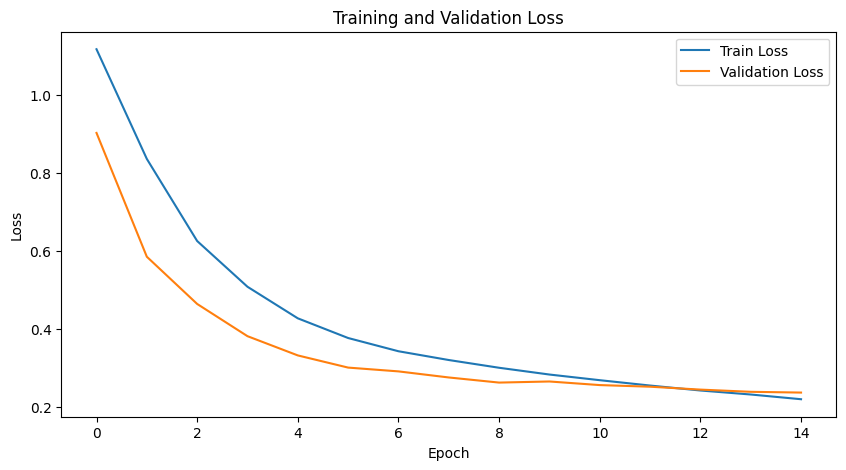

In [39]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

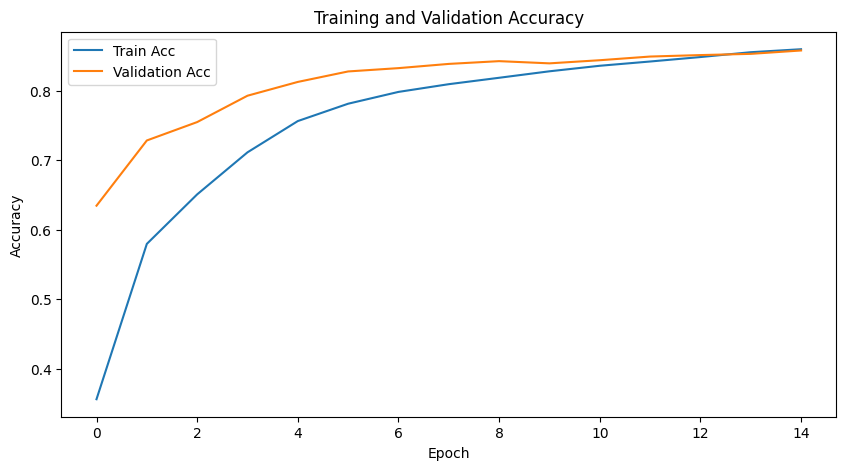

In [40]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluasi Model ##

Train Accuracy: 0.8601
Classification Report for Data Training:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4893
           1       0.89      0.85      0.87      4898
           2       0.89      0.87      0.88      4837
           3       0.90      0.90      0.90      4904
           4       0.83      0.85      0.84      3427
           5       0.80      0.84      0.82      4904

    accuracy                           0.86     27863
   macro avg       0.86      0.86      0.86     27863
weighted avg       0.86      0.86      0.86     27863



(0.0, 1.0, 0.0, 1.0)

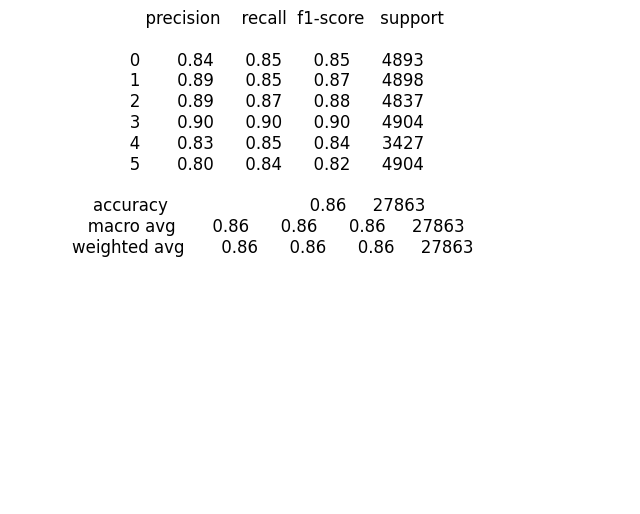

In [41]:
# Evaluasi model Pada data training
train_accuracy = accuracy_score(train_true_labels, train_predictions)
train_classification_rep = classification_report(train_true_labels, train_predictions)
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Classification Report for Data Training:\n{train_classification_rep}')
# Membuat plot kosong
plt.figure(figsize=(8, 6))  # Ubah ukuran gambar sesuai kebutuhan
# Menambahkan teks laporan ke dalam plot
plt.text(0.1, 0.5, train_classification_rep, {'fontsize': 12})
# Menghilangkan sumbu
plt.axis('off')

In [42]:
cm_train = confusion_matrix(train_true_labels, train_predictions)
cm_train

array([[4144,  164,   67,  141,   83,  294],
       [ 159, 4186,  146,   56,  159,  192],
       [ 103,  140, 4186,  130,  145,  133],
       [  96,   16,   57, 4403,   57,  275],
       [  49,   77,  123,   87, 2928,  163],
       [ 360,  138,   99,   51,  138, 4118]])

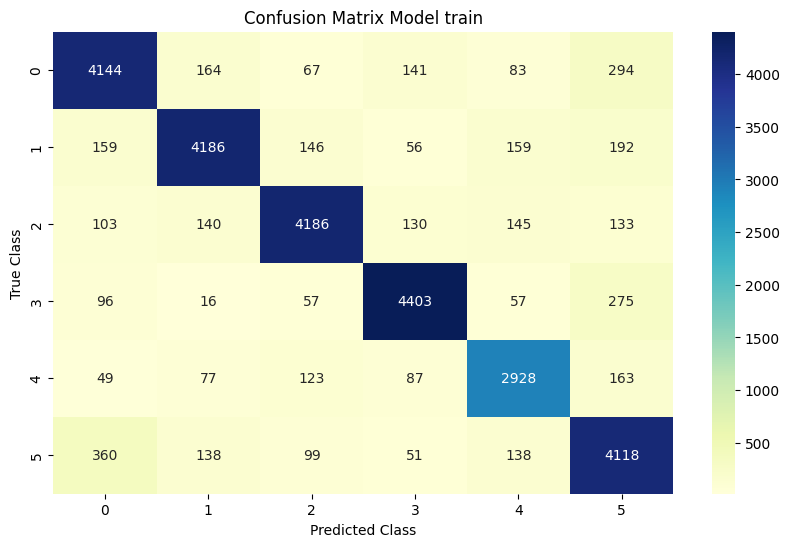

In [43]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cm_train, annot = True, fmt = "d", cmap= 'YlGnBu')
# Labeling the X-axis
plt.xlabel("Predicted Class")
# Labeling the Y-axis
plt.ylabel("True Class")
# Give a title to the graph
plt.title("Confusion Matrix Model train")
plt.show()

Val Accuracy: 0.8585
Classification Report for Data Validation:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       541
           1       0.81      0.78      0.80       365
           2       0.93      0.88      0.91      1117
           3       0.96      0.87      0.91      1226
           4       0.52      0.80      0.63       132
           5       0.66      0.83      0.74       350

    accuracy                           0.86      3731
   macro avg       0.78      0.84      0.80      3731
weighted avg       0.87      0.86      0.86      3731



(0.0, 1.0, 0.0, 1.0)

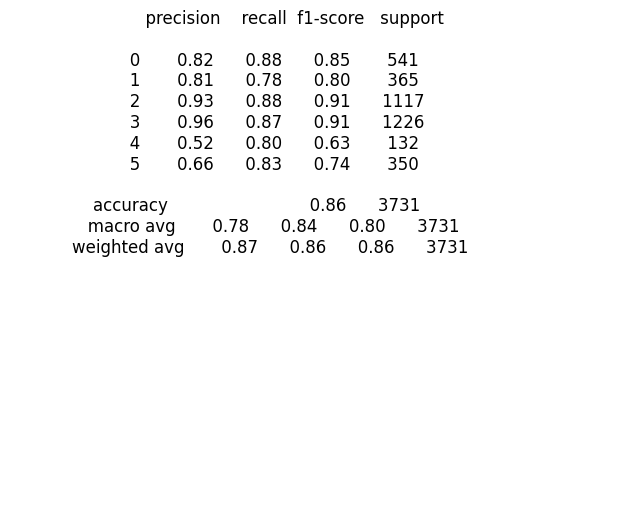

In [44]:
# Evaluasi model Pada data validasi
val_accuracy = accuracy_score(val_true_labels, val_predictions)
val_classification_rep = classification_report(val_true_labels, val_predictions)
print(f'Val Accuracy: {val_accuracy:.4f}')
print(f'Classification Report for Data Validation:\n{val_classification_rep}')
# Membuat plot kosong
plt.figure(figsize=(8, 6))  # Ubah ukuran gambar sesuai kebutuhan
# Menambahkan teks laporan ke dalam plot
plt.text(0.1, 0.5, val_classification_rep, {'fontsize': 12})
# Menghilangkan sumbu
plt.axis('off')

In [45]:
cm_val = confusion_matrix(val_true_labels, val_predictions)
cm_val

array([[ 474,   17,    8,    6,    9,   27],
       [  17,  286,   17,    7,   15,   23],
       [  19,   32,  987,   23,   29,   27],
       [  34,   10,   26, 1061,   31,   64],
       [   5,    3,    8,    3,  105,    8],
       [  26,    6,   13,    3,   12,  290]])

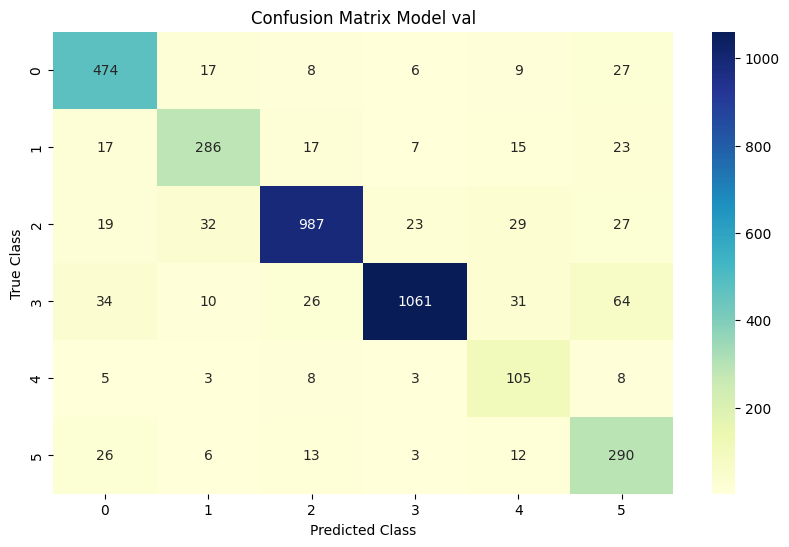

In [46]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cm_val, annot = True, fmt = "d", cmap= 'YlGnBu')

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix Model val")
plt.show()

In [47]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

# Pastikan model dalam mode evaluasi
model.eval()

# Simpan label prediksi dan label sebenarnya
test_predictions = []  # Simpan label prediksi untuk classification report & confusion matrix
test_true_labels = []  # Simpan label asli
test_probs = []  # Simpan probabilitas untuk ROC AUC

# Evaluasi pada data uji
for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_input_masks = batch[1].to(device)
    batch_labels = batch[2].to('cpu').numpy()  # Simpan label asli

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_input_masks)
    
    logits = outputs.logits  # Logits dari model
    probs = F.softmax(logits, dim=1).to('cpu').numpy()  # Konversi ke probabilitas
    pred_labels = np.argmax(probs, axis=1)  # Ambil label dengan probabilitas tertinggi

    test_probs.extend(probs)  # Simpan probabilitas untuk ROC AUC
    test_predictions.extend(pred_labels)  # Simpan label prediksi untuk evaluasi lain
    test_true_labels.extend(batch_labels)  # Simpan label asli

print("Done")

Done


Test Accuracy: 0.8574
Classification Report for Data Testing:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       677
           1       0.79      0.81      0.80       455
           2       0.94      0.88      0.91      1397
           3       0.96      0.88      0.92      1533
           4       0.52      0.78      0.63       164
           5       0.64      0.79      0.71       438

    accuracy                           0.86      4664
   macro avg       0.78      0.83      0.80      4664
weighted avg       0.87      0.86      0.86      4664



(0.0, 1.0, 0.0, 1.0)

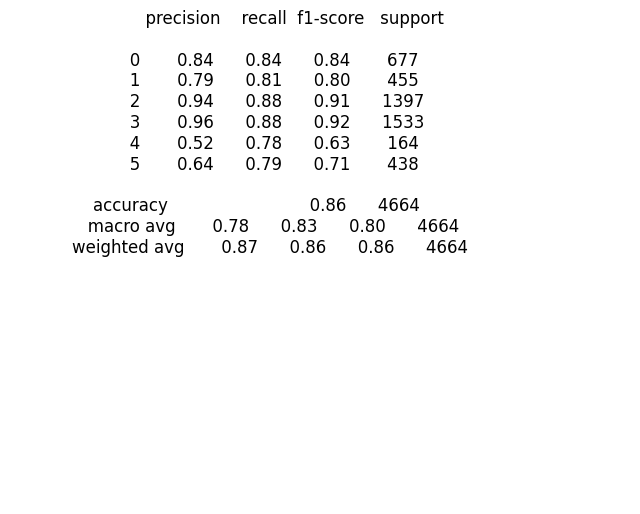

In [48]:
# Evaluasi model for Data Testing
test_accuracy = accuracy_score(test_true_labels, test_predictions)
classification_rep = classification_report(test_true_labels, test_predictions)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Classification Report for Data Testing:\n{classification_rep}')
# Membuat plot kosong
plt.figure(figsize=(8, 6))  # Ubah ukuran gambar sesuai kebutuhan
# Menambahkan teks laporan ke dalam plot
plt.text(0.1, 0.5, classification_rep, {'fontsize': 12})
# Menghilangkan sumbu
plt.axis('off')

In [49]:
cm_test = confusion_matrix(test_true_labels, test_predictions)
cm_test

array([[ 571,   25,   18,   10,   14,   39],
       [  12,  370,   27,    4,   19,   23],
       [  23,   41, 1227,   32,   43,   31],
       [  29,    7,   18, 1355,   26,   98],
       [   4,    9,    9,    8,  128,    6],
       [  43,   14,   12,    7,   14,  348]])

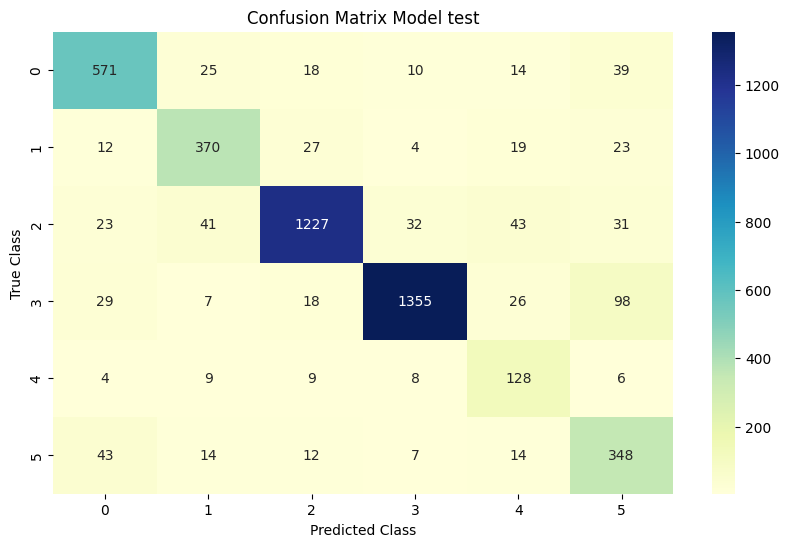

In [50]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cm_test, annot = True, fmt = "d", cmap= 'YlGnBu')

# Labeling the X-axis
plt.xlabel("Predicted Class")
# Labeling the Y-axis
plt.ylabel("True Class")
# Give a title to the graph
plt.title("Confusion Matrix Model test")
plt.show()

## Cek Misclassification ##

In [51]:
# 1. Mapping label angka ke label teks
label_mapping = {
    0: 'Anxiety',
    1: 'Bipolar',
    2: 'Depression',
    3: 'Normal',
    4: 'Personality disorder',
    5: 'Stress'
}

# 2. Ambil teks dari data_test
test_texts = data_test['statement'].tolist()

# 3. Buat DataFrame hasil prediksi
df_results = pd.DataFrame({
    'Text': test_texts,
    'True_Label': test_true_labels,
    'Predicted_Label': test_predictions
})

# 4. Ubah label angka ke bentuk teks
df_results['True_Label'] = df_results['True_Label'].map(label_mapping)
df_results['Predicted_Label'] = df_results['Predicted_Label'].map(label_mapping)

# 5. Filter data yang salah prediksi
df_misclassified = df_results[df_results['True_Label'] != df_results['Predicted_Label']]

# 6. Tampilkan jumlah dan isi data salah prediksi
print(f"Jumlah data salah prediksi: {len(df_misclassified)}")
df_misclassified

Jumlah data salah prediksi: 665


,Text,True_Label,Predicted_Label
2,did everyone else get strip searched when they...,Bipolar,Depression
10,omg revision revision revision i feel like i w...,Normal,Personality disorder
20,i am not the type to talk to people but i did ...,Depression,Personality disorder
28,i need advice ive had crohns since i was years...,Anxiety,Depression
37,i get home and go to bed and then struggle get...,Stress,Depression
...,...,...,...
4590,small victory saturday back by unpopular deman...,Bipolar,Normal
4608,has anyone ever been in an extended stay hospi...,Bipolar,Stress
4614,do i live in this cycle forever is there reall...,Stress,Personality disorder
4617,i was able to get my old office job back and t...,Stress,Normal


In [52]:
# Menampilkan teks utuh baris ke-3 (indeks ke-2 karena mulai dari 0)
print(df_misclassified.iloc[0]['Text'])

did everyone else get strip searched when they were sent to the mental hospital or went voluntarily ig i didnt i felt like i was treated like a criminal i felt so violated i wasnt overweight i was fit at the time but it still felt so degrading i remember liking how i looked as i took off my clothes and stood there they just got all giggly and excited and said ooh a blonde after i literally hated my body i felt like it took everything sexual away from my body sorry tmi i didnt eat for days after then binged on the worst hospital food i wish i said no it literally affected me a lot more than it should have but it was a week after i turned so like it just felt weird to me the age isnt important it can feel weird to anyone idk im being salty idk its another late night and i cant stop thinking about the mental hospital again even tho i was there almost a year ago i think about it less now tho which is good sorry i sound soooo grouchy i think everyone had to go thru this as well right


In [53]:
df_misclassified.to_csv("Data_missclassification_BT(KOMPRE12juni).csv", index=False)

In [54]:
# Hitung frekuensi label asli yang paling banyak salah prediksi
error_counts = df_misclassified['True_Label'].value_counts()

print("\nFrekuensi salah prediksi berdasarkan label asli:")
print(error_counts)

# Jika ingin tampilkan label dan jumlah salahnya secara rapi
error_summary = error_counts.reset_index()
error_summary.columns = ['Label_Asli', 'Jumlah_Salah_Prediksi']
print("\nRingkasan kesalahan prediksi per label asli:")
print(error_summary)


Frekuensi salah prediksi berdasarkan label asli:
True_Label
Normal                  178
Depression              170
Anxiety                 106
Stress                   90
Bipolar                  85
Personality disorder     36
Name: count, dtype: int64

Ringkasan kesalahan prediksi per label asli:
             Label_Asli  Jumlah_Salah_Prediksi
0                Normal                    178
1            Depression                    170
2               Anxiety                    106
3                Stress                     90
4               Bipolar                     85
5  Personality disorder                     36


## ROC-AUC ##

In [55]:
class_labels = ['Anxiety','Bipolar','Depression','Normal', 'Personality disorder','Stress']

Shape of test_true_labels: (4664, 6)
Shape of test_predictions: (4664, 6)
ROC AUC Score: 0.9021319623644066


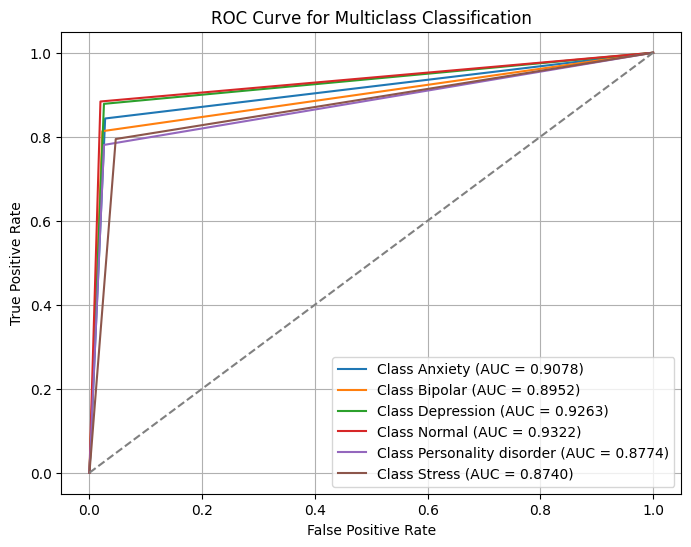

In [56]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Pastikan test_predictions dalam bentuk NumPy array
test_predictions = np.array(test_predictions)

# Jika test_predictions hanya berupa label kategori, ubah ke one-hot encoding
if test_predictions.ndim == 1:  # Jika masih 1D (berisi label kategori)
    encoder = OneHotEncoder(sparse=False)
    test_predictions = encoder.fit_transform(test_predictions.reshape(-1, 1))

# Pastikan test_true_labels dalam bentuk NumPy array
test_true_labels = np.array(test_true_labels)

# Pastikan test_true_labels dalam bentuk one-hot encoding
if test_true_labels.ndim == 1:  # Jika masih 1D
    test_true_labels = encoder.fit_transform(test_true_labels.reshape(-1, 1))

# Pastikan jumlah kelas sesuai dengan panjang class_labels
n_classes = len(class_labels)

# Cek dimensi setelah perbaikan
print("Shape of test_true_labels:", test_true_labels.shape)
print("Shape of test_predictions:", test_predictions.shape)

# Hitung ROC AUC Score
roc_auc = roc_auc_score(test_true_labels, test_predictions, multi_class='ovr')
print('ROC AUC Score:', roc_auc)

# Plot ROC Curve untuk tiap kelas
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_labels[:, i], test_predictions[:, i])  # One-vs-Rest per kelas
    auc_score = roc_auc_score(test_true_labels[:, i], test_predictions[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Garis diagonal sebagai baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()